<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT23/blob/jonahaag_lab1/Lab1/jonahaag_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Lab 1, Jonathan Haag**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2023 Johan Hoffman (jhoffman@kth.se), Jonathan Haag (jmhaag@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-03-26 14:13:52--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-03-26 14:13:52 (44.8 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/f865b92/releases/pybind11-install.s

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

**Define domain and mesh**

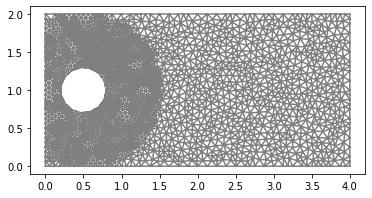

In [29]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32 # Uniform mesh size h = 1/resolution
x_circle = 0.125*L
y_circle = 0.5*H
r_circle = 0.3

mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(x_circle,y_circle),r_circle), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1 # We want to refine the mesh once
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(x_circle,y_circle)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [98]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
# VE = VectorElement("CG", mesh.ufl_cell(), 1) # not inf sup stable
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions**

In [102]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
#uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # flow from right to left
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
#ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
#ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
ib = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) # flow from right to left
ob = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element()) # flow from right to left
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**

In [103]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )
# Including the Brezzi-Pitkäranta stabilization with C_2 = 0.1
#residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 0.1*h*h*inner(grad(p), grad(q))*dx + 
#            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w) 

**Visualize solution and export files**

rm: cannot remove 'results-Stokes/*': No such file or directory


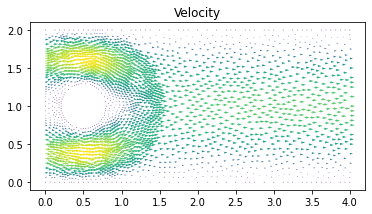

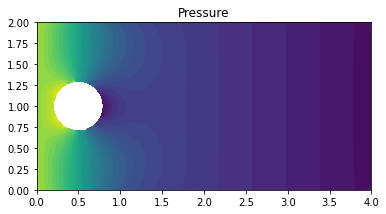

In [104]:
!rm results-Stokes/*

# Open files to export solution to Paraview
#file_u = File("results-Stokes/u.pvd")
#file_p = File("results-Stokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
#file_u << u1
#file_p << p1

# Plot solution
plt.figure()
plot(u1, title="Velocity")
#plt.savefig("u4.png", dpi=150)

plt.figure()
plot(p1, title="Pressure")
#plt.savefig("p4.png", dpi=150)
        
plt.show()


# Export files
#!tar -czvf results-Stokes.tar.gz results-Stokes
#files.download('results-Stokes.tar.gz')
#files.download('u4.png')
#files.download('p4.png')

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past one circular obstacle. 

First, the mesh generation was investigated by trying different configurations of the position and size of the circluar obstacle as well as initial mesh resolution and refinement steps. The mesh as shown in section 'Define domain and mesh' was used for the remainder of the lab. It contains one circular obstacle with center (0.125 $⋅$ L, 0.5 $⋅$ H) and radius 0.3. The local mesh within radius one around that obstacle was refined once.

Then, function spaces $Q$ and $V$ of different orders were examined in terms of their effect on the stability of the solution. Using a mixed-order approach, we obtain the expected solution as shown below with the laminar flow around the obstacle and high pressure at the central impact point.



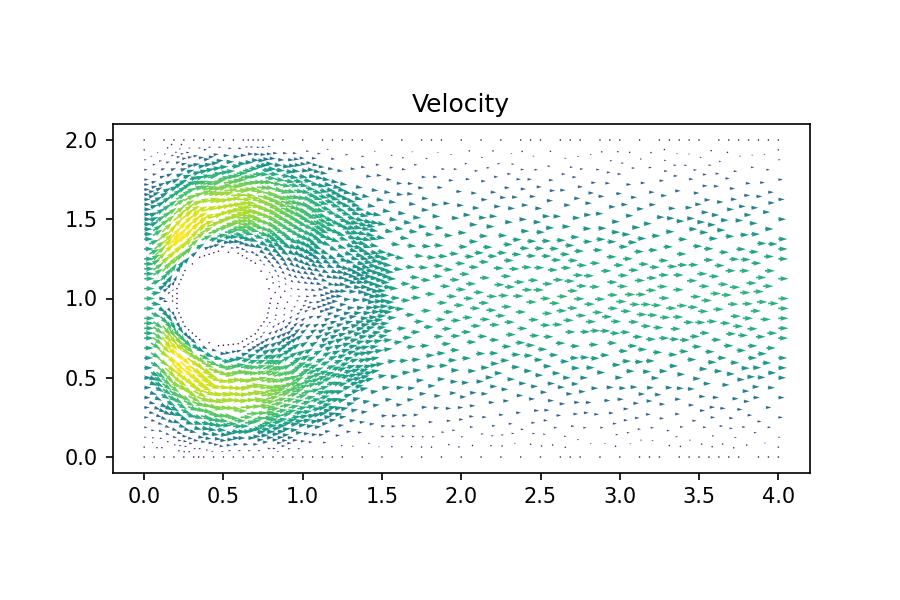
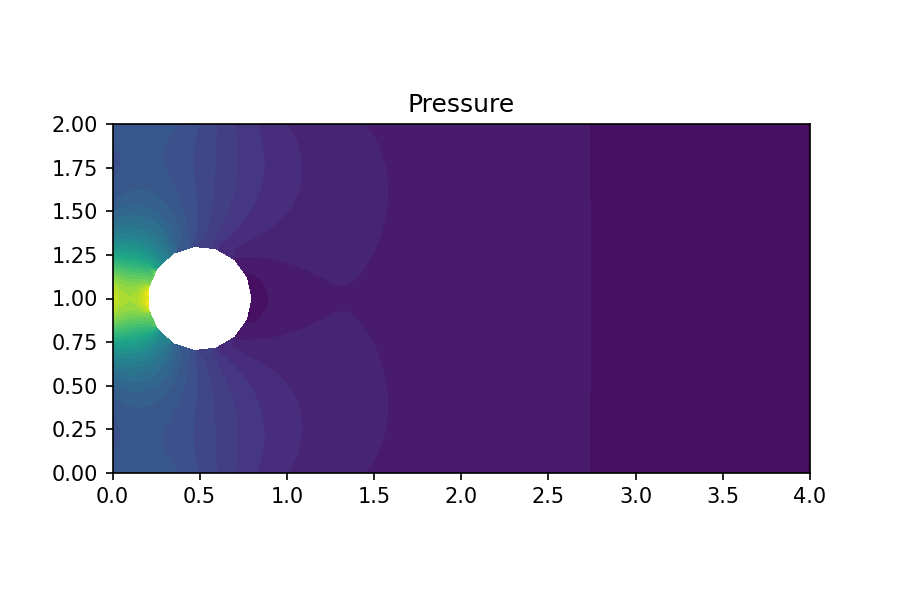

Compare this to the results when using function spaces of order 1 for both $Q$ and $V$. In this case, we get a similar looking velocity profile, but can clearly see the instability in the pressure profile as it looks non-smooth and granular, i.e., unphysical.

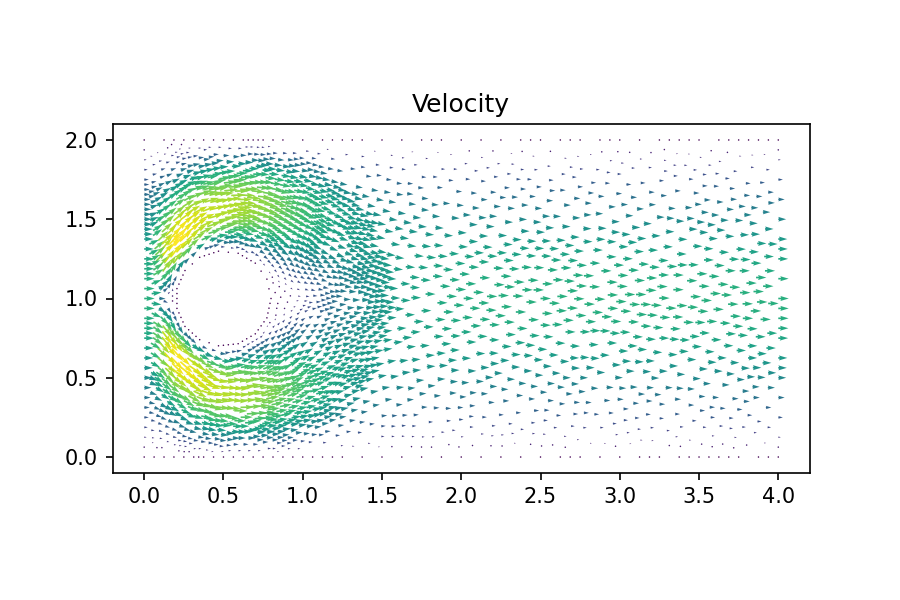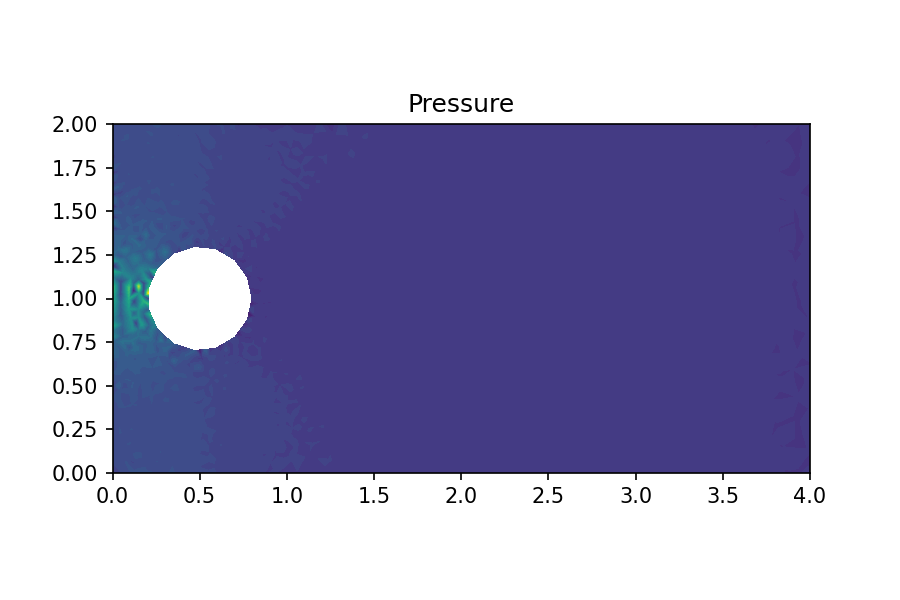

To avoid this problem, we can implement the Brezzi-Pitkäranta stabilization by simply adding another term to the variational problem. The residual can then be expressed as

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) + C_2 h^2(\nabla p, \nabla q) - (f,v)$.

Here, we also introduce an additional constant parameter $C_2$ which was set to 0.1 for this comparison. If we rerun the simulation, we again obtain a stable solution, even when using linear approximation spaces for $u$ and $p$. The results for the velocity and pressure are shown below.

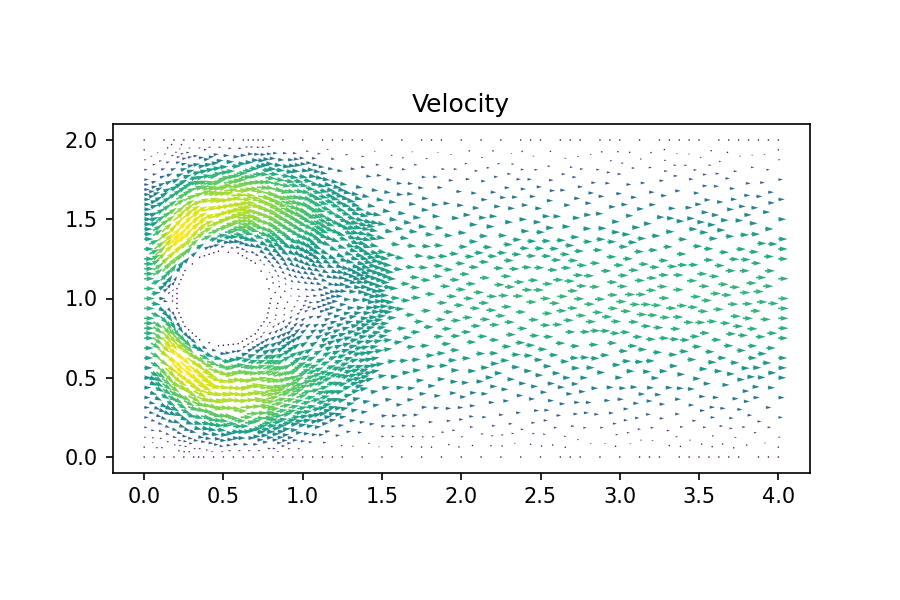
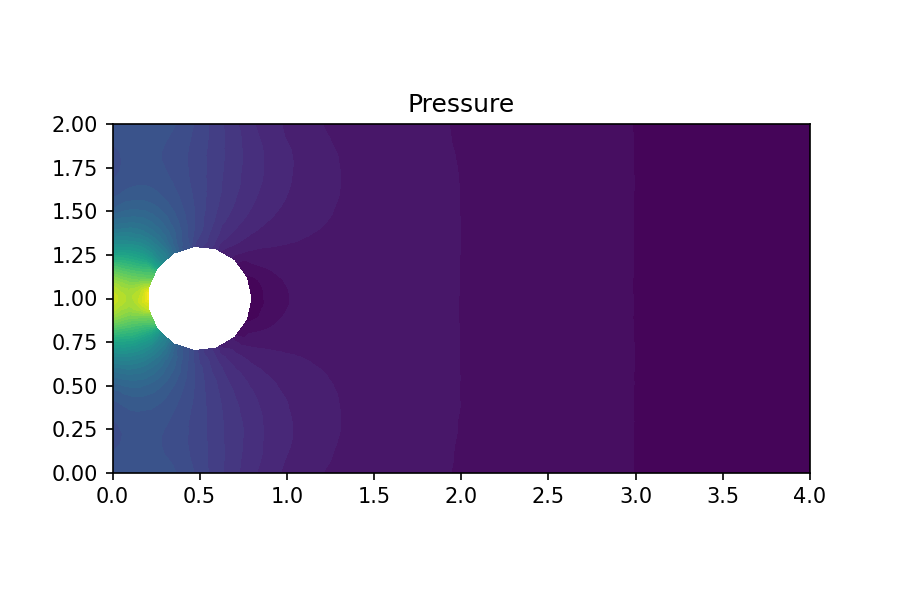